In [28]:
import platform
print(platform.python_version()) # >=3.7.1rc1 required for dataclass
from dataclasses import dataclass
from enum import Enum
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import random
from abc import ABC, abstractmethod


3.8.10


In [25]:
class Deck:
    def __init__(self, seed:int=42):
        self.seed = seed
        random.seed(self.seed)
        self._cards = list(range(1, 10)) + [10] * 4

    def draw(self) -> int:
        return random.choice(self._cards)

In [68]:
# test the deck out
deck = Deck()
assert(len(deck._cards) == 13)

distribution = {}
for i in range(0, int(1e4)):
    card = deck.draw()
    distribution[card] = distribution.get(card, 0) + 1

for card, count in distribution.items():
    print(card, count) # 10 should have roughly 4x more than others

10 3179
2 780
1 714
5 752
4 723
3 782
9 775
7 743
8 791
6 761


In [69]:
# helper function to get sum of cards, considering whether to use ace as 11 or not
def SumCards(cards) -> int:
    if 1 in cards:
        if sum(cards) + 10 <= 21:
            return sum(cards) + 10
        else:
            return sum(cards)
    else:
        return sum(cards)

# test
assert(SumCards([2,3]) == 5)
assert(SumCards([1,5]) == 16)
assert(SumCards([1,5,10]) == 16)
assert(SumCards([1,1]) == 12)
assert(SumCards([1,1,1]) == 13)

In [72]:
# MDP classes
@dataclass
class State:
    CurrentSum: int
    ShowingCardFromDealer: int
    HasUsableAce: bool

    def __str__(self):
        return "%d-%d-%s" % (self.CurrentSum, self.ShowingCardFromDealer, self.HasUsableAce)

class Action(Enum):
    HIT = 1
    STICK = 2

In [63]:
class Policy(ABC):
    def __init__(self, debug=False):
        self._Debug = debug

    @abstractmethod
    def pi(self, state:State) -> Action:
        ...

In [64]:
class Policy1(Policy):
    def pi(self, state:State, is_first:bool=False) -> Action:
        if self._Debug:
            print("[policy debug] received state", state)
        if state.CurrentSum >= 20:
            return Action.STICK
        else:
            return Action.HIT

In [82]:
class BlackjackEnv:
    def __init__(self, seed:int = 42, debug = False):
        self._Deck = Deck(seed)
        self._Debug = debug
        self._DealerCards = []
        self._PlayerCards = []
        self._state = None

    def reset(self) -> (State, int, bool):
        self._DealerCards = []
        self._PlayerCards = []
        self._state = None

        PlayerCards = [self._Deck.draw(), self._Deck.draw()]
        DealerCards = [self._Deck.draw(), self._Deck.draw()]

        self._PlayerCards = PlayerCards
        self._DealerCards = DealerCards

        if self._Debug:
            print("[env debug] player's first two cards: ", PlayerCards)
            print("[env debug] dealer's first two cards: ", DealerCards)

        state = State(
            SumCards(PlayerCards),
            DealerCards[0],
            1 in PlayerCards and sum(PlayerCards) + 10 <= 21
        )
        self._state = state

        if set(PlayerCards) == set([1,10]):
            if set(DealerCards) == set([1,10]): # draw
                return (state, 0, True)
            else: # win
                return (state, 1, True)
        else: # game continues
            return (state, 0, False)

    def step(self, action:Action) -> (State, int, bool):
        if action == Action.STICK:
            # dealer sticks when sum >= 17, and hit otherwise
            # dealer loses if goes bust, else compare final sum
            DealerSum = SumCards(self._DealerCards)
            while DealerSum < 17:
                card = self._Deck.draw()
                if self._Debug:
                    print("[env debug] draw card for dealer", card)
                self._DealerCards.append(card)
                DealerSum = SumCards(self._DealerCards)
            if DealerSum > 21: # dealer goes bust
                return (self._state, 1, True)

            # compare final sum
            if self._state.CurrentSum > DealerSum:
                return (self._state, 1, True)
            elif self._state.CurrentSum == DealerSum:
                return (self._state, 0, True)
            else:
                return (self._state, -1, True)
        else:
            # draw one more card for player
            card = self._Deck.draw()
            self._PlayerCards.append(card)
            if self._Debug:
                print("[env debug] draw card for player", card, self._PlayerCards)
            PlayerSum = SumCards(self._PlayerCards)
            state = State(
                PlayerSum,
                self._state.ShowingCardFromDealer,
                1 in self._PlayerCards and sum(self._PlayerCards) + 10 <= 21
            )
            self._state = state

            # check if player has busted or not
            if PlayerSum > 21:
                return (state, -1, True)
            else:
                return (state, 0, False)

    def info(self):
        print("[env info] player cards:", self._PlayerCards)
        print("[env info] dealer cards:", self._DealerCards)

In [83]:
def simulate(env, policy):
    observation, reward, done = env.reset()
    game = [observation]
    if done:
        return (game, reward)
    else:
        action = policy.pi(observation, is_first=True)
        observation, reward, done = env.step(action)
        game = game + [action, observation]

        while not done:
            action = policy.pi(observation)
            observation, reward, done = env.step(action)
            game = game + [action, observation]

        return (game, reward)

In [84]:
# test blackjack env
env = BlackjackEnv(seed=42, debug=True)
policy = Policy1(debug=True)

game, reward = simulate(env, policy)
for i in game:
    print("[game]", i)
print(reward)
env.info()

[env debug] player's first two cards:  [10, 2]
[env debug] dealer's first two cards:  [1, 10]
[policy debug] received state 12-1-False
[env debug] draw card for player 5 [10, 2, 5]
[policy debug] received state 17-1-False
[env debug] draw card for player 4 [10, 2, 5, 4]
[policy debug] received state 21-1-False
[game] 12-1-False
[game] Action.HIT
[game] 17-1-False
[game] Action.HIT
[game] 21-1-False
[game] Action.STICK
[game] 21-1-False
0
[env info] player cards: [10, 2, 5, 4]
[env info] dealer cards: [1, 10]


In [85]:
# visualize policy graph w.r.t total 200 possible states
def visualize(policy:Policy):

    def stick_cutoff(HasUsableAce:bool):
        # get the separation between HIT and STICK
        result = []
        for ShowingCardFromDealer in range(1, 11):
            for PlayerSum in range(12, 22):
                state = State(PlayerSum, ShowingCardFromDealer, HasUsableAce)
                action = policy.pi(state)
                if action == Action.STICK:
                    result.append(PlayerSum)
                    break
        return result

    ys_with_ace = stick_cutoff(True)
    ys_without_ace = stick_cutoff(False)

    plt.figure(1)
    plt.subplots_adjust(wspace = 0.5)

    plt.subplot(121)
    plt.title("with usable ace")
    plt.xlabel("dealer showing")
    plt.ylabel("player sum")
    plt.xticks(np.arange(1,11,1))
    plt.yticks(np.arange(12,22,1))
    plt.plot(list(range(1,11)),ys_with_ace)

    plt.subplot(122)
    plt.title("without usable ace")
    plt.xlabel("dealer showing")
    plt.ylabel("player sum")
    plt.xticks(np.arange(1,11,1))
    plt.yticks(np.arange(12,22,1))
    plt.plot(list(range(1,11)),ys_without_ace)

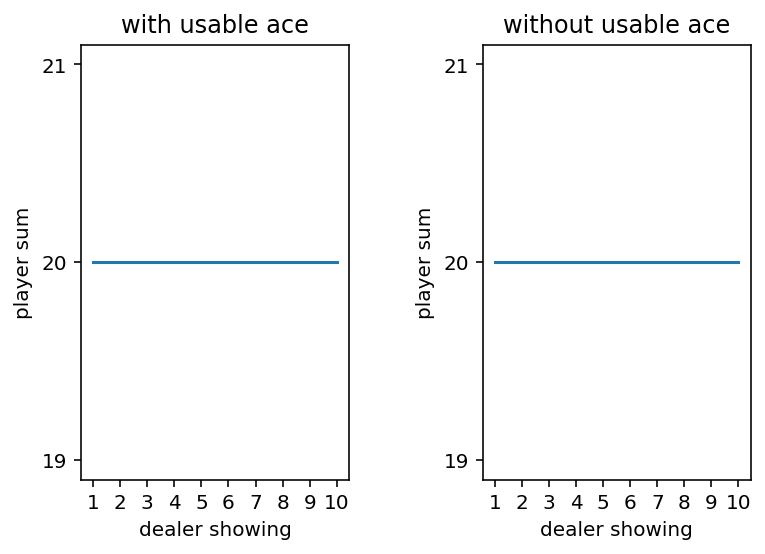

In [86]:
visualize(Policy1())

In [93]:
class MCPolicy(Policy):
    def __init__(self, seed=42, debug=False):
        self.initialise_q()
        self.seed = seed
        super().__init__(debug)

    def initialise_q(self):
        self.q = {}
        for PlayerSum in range(12, 22):
            for ShowingCardFromDealer in range(1, 11):
                for HasUsableAce in [True, False]:
                    state = State(PlayerSum, ShowingCardFromDealer, HasUsableAce)
                    self.q[str(state)] = {
                        Action.HIT: {"count":0, "q":0.0},
                        Action.STICK: {"count":0, "q":0.0}
                    }

    def pi(self, state:State, is_first:bool=False) -> Action:
        if self._debug:
            print("[policy debug] received state", state)
        if state.CurrentSum <= 11:
            return Action.HIT
        else:
            if is_first: # exploring start
                if self._debug:
                    print("[policy debug] exploring starts")
                return random.choice([Action.HIT, Action.STICK])
            else:
                q = self.q[str(state)]
                if q[Action.HIT]['q'] > q[Action.STICK]['q']:
                    return Action.HIT
                elif q[Action.HIT]['q'] < q[Action.STICK]['q']:
                    return Action.STICK
                else:
                    return random.choice([Action.HIT, Action.STICK])

    def update_q(self, game, reward):
        seen = set()
        for (state, action) in [(game[i], game[i+1]) for i in range(0, len(game)-1, 2)]:
            key = "%r-%s" % (state, action)
            if key not in seen:
                seen.add(key)
                # incrementally update average
                if str(state) in self.q.keys():
                    # this if is necessary because we may receive state where PlayerSum <= 11
                    # in this case we always HIT, so it's not an interesting space
                    NewCount = self.q[str(state)][action]['count'] + 1
                    CurrentAverage = self.q[str(state)][action]['q']
                    NewAverage = CurrentAverage + 1./NewCount*(reward-CurrentAverage)
                    self.q[str(state)][action]['count'] = NewCount
                    self.q[str(state)][action]['q'] = NewAverage

    def show(self):
        for state in self.q.keys():
            if self.q[state][Action.HIT]['count'] > 0 or self.q[state][Action.STICK]['count'] > 0:
                print("[policy debug] updated q value for state ", state, self.q[state])

In [94]:
debug = False
seed = 42
policy = MCPolicy(seed=seed, debug=debug)
env = BlackjackEnv(seed=seed+1, debug=debug)

for i in range(int(200)):
    if i % 10 == 0:
        print("iteration ", i)
    game,reward = simulate(env, policy)
    policy.update_q(game, reward)

iteration  0
iteration  10
iteration  20
iteration  30
iteration  40
iteration  50
iteration  60
iteration  70
iteration  80
iteration  90
iteration  100
iteration  110
iteration  120
iteration  130
iteration  140
iteration  150
iteration  160
iteration  170
iteration  180
iteration  190


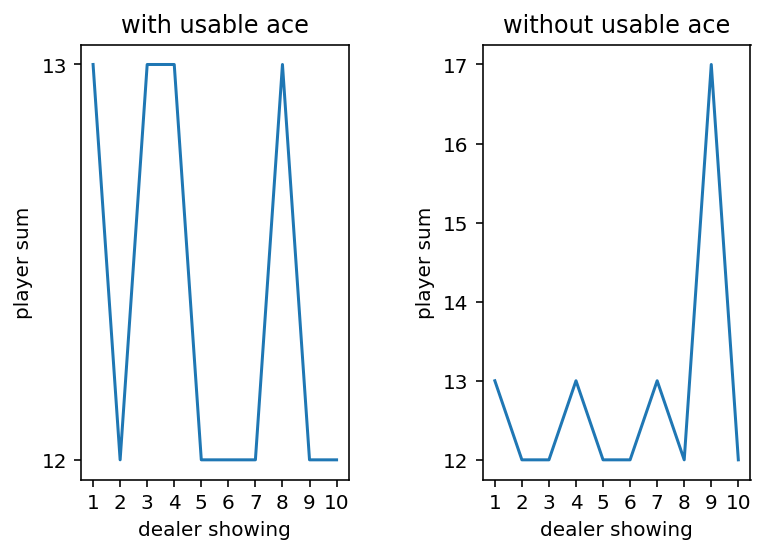

In [95]:
visualize(policy)

In [96]:
# for debug purpose
for s in range(12,22):
    state = State(s, 4, True)
    print(s, policy.pi(state), policy.q[str(state)])

12 Action.HIT {<Action.HIT: 1>: {'count': 0, 'q': 0.0}, <Action.STICK: 2>: {'count': 0, 'q': 0.0}}
13 Action.STICK {<Action.HIT: 1>: {'count': 0, 'q': 0.0}, <Action.STICK: 2>: {'count': 0, 'q': 0.0}}
14 Action.STICK {<Action.HIT: 1>: {'count': 0, 'q': 0.0}, <Action.STICK: 2>: {'count': 0, 'q': 0.0}}
15 Action.STICK {<Action.HIT: 1>: {'count': 0, 'q': 0.0}, <Action.STICK: 2>: {'count': 0, 'q': 0.0}}
16 Action.HIT {<Action.HIT: 1>: {'count': 0, 'q': 0.0}, <Action.STICK: 2>: {'count': 0, 'q': 0.0}}
17 Action.STICK {<Action.HIT: 1>: {'count': 0, 'q': 0.0}, <Action.STICK: 2>: {'count': 0, 'q': 0.0}}
18 Action.HIT {<Action.HIT: 1>: {'count': 0, 'q': 0.0}, <Action.STICK: 2>: {'count': 0, 'q': 0.0}}
19 Action.HIT {<Action.HIT: 1>: {'count': 0, 'q': 0.0}, <Action.STICK: 2>: {'count': 0, 'q': 0.0}}
20 Action.HIT {<Action.HIT: 1>: {'count': 0, 'q': 0.0}, <Action.STICK: 2>: {'count': 0, 'q': 0.0}}
21 Action.HIT {<Action.HIT: 1>: {'count': 0, 'q': 0.0}, <Action.STICK: 2>: {'count': 0, 'q': 0.0}}
